In [2]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from image_downloading import  run, image_size
from geo_func import split_polygon, read_geopandas_data
import time
from shapely.geometry import Point, Polygon
from matplotlib.path import Path

## Choosing ward of Dalat city

In [114]:
# ward="12"
# geo = read_geopandas_data(province="Lâm Đồng", district="Đà Lạt",ward="12")
ward="Nguyễn Cư Trinh"
geo = read_geopandas_data(province="Hồ Chí Minh city", district="Quận 1",ward=ward)
G = np.random.choice(geo.geometry.values)
 
squares = split_polygon(G, shape='square', thresh=0, side_length=0.005)
geo_series = gpd.GeoSeries(squares)

## Render mask process

In [118]:
tf_lon, _, _, tf_lat = geo_series[geo_series.index[-1]-8+1].bounds #this is top-left square
_, br_lat, br_lon, _ = geo_series[0].bounds #this is bottom-right square

In [119]:
tf_lon,tf_lat, br_lat, br_lon

(108.4659881591798, 11.992591857910156, 11.954291343689022, 108.50731658935553)

In [120]:
W, H = image_size(tf_lat, tf_lon, br_lat, br_lon, zoom=19)
W, H

(15408, 14598)

In [101]:
#this index is specified for ward 12
tf_lon, _, _, tf_lat = geo_series[geo_series.index[-1]-2+1].bounds #this is top-left square
_, br_lat, br_lon, _ = geo_series[0].bounds #this is bottom-right square

start = time.time()

W, H = image_size(tf_lat, tf_lon, br_lat, br_lon, zoom=19)
# W = geo_series[0].shape[0]*(W//geo_series[0].shape[0])
# H = geo_series[0].shape[1]*(H//geo_series[0].shape[1])
print(W,H)
dx = (br_lon-tf_lon)/W
dy = (tf_lat-br_lat)/H

valuesx = np.arange(0, W)
oney = np.ones((1,H), dtype=int)
image_dx = valuesx.reshape((W,1))*oney

valuesy = np.arange(H,0, -1)
onex = np.ones((W,1), dtype=int)
image_dy = valuesy.reshape((1,H))*onex

lon = np.add(image_dx*dx, tf_lon)
lat = np.add(image_dy*dy, br_lat)

area = {}
boundary = Polygon(geo_series[geo_series.index[0]])

path = Path(list(boundary.exterior.coords))  # Create Path from Polygon's vertices


def is_point_inside_polygon(point):
    return path.contains_point(point)

mask = np.full(lat.shape, False, dtype=bool)
# Check if point is inside the polygon
#mask = np.array([[is_point_inside_polygon((lon[i][j], lat[i][j])) for j in range(W)] for i in range(H)], dtype=bool)
print(lon.shape, lat.shape)
for i in range(W):
    if(i%500 == 0):
        print(time.time()-start)
    for j in range(H):
        mask[i,j] = is_point_inside_polygon((lon[i][j], lat[i][j]))

np.save("mask_"+ward, mask)

4366 4530
(4366, 4530) (4366, 4530)
0.515998125076294
6.308020114898682
11.783046245574951
17.283995151519775
22.949034452438354
28.56099510192871
34.0990207195282
39.64718747138977
45.19418001174927


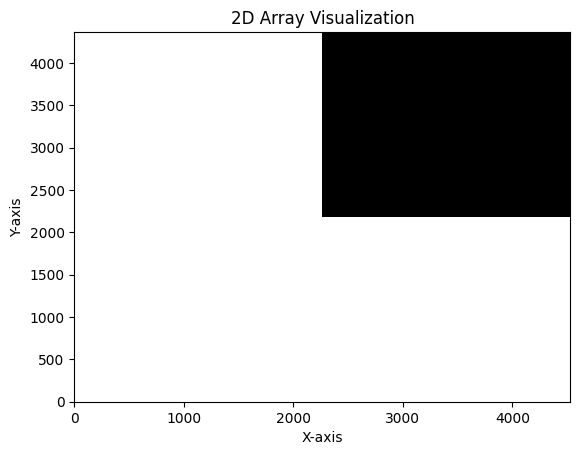

In [38]:
mask_12 = np.load("mask_Nguyễn Cư Trinh.npy")
plt.pcolormesh(mask_12, cmap="binary")  
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("2D Array Visualization")
plt.show()

## Inference model result

In [4]:
!pip install torch==1.13.0+cpu torchvision==0.14.0+cpu torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1


You should consider upgrading via the 'd:\code\real_estate\.venv\scripts\python.exe -m pip install --upgrade pip' command.


In [9]:
!pip install mmcv==2.0.0rc3 -f https://download.openmmlab.com/mmcv/dist/cpu/torch1.13/index.html

Looking in links: https://download.openmmlab.com/mmcv/dist/cpu/torch1.13/index.html


You should consider upgrading via the 'd:\code\real_estate\.venv\scripts\python.exe -m pip install --upgrade pip' command.


In [12]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot

In [17]:
config_file = 'segformer_mit-b5_8xb2-160k_loveda-640x640.py'
checkpoint_file = 'segformer.pth'
model = init_model(config_file, checkpoint_file, device='cpu')
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)

d:\code\real_estate\.venv\lib\site-packages\mmseg\models\builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '


Loads checkpoint by local backend from path: segformer.pth


In [19]:
file = "data/images/Hồ Chí Minh city/Quận 1/Nguyễn Cư Trinh/0.png"
result = inference_model(model, file)

In [20]:
result

<SegDataSample(

    META INFORMATION
    img_path: 'data/images/Hồ Chí Minh city/Quận 1/Nguyễn Cư Trinh/0.png'
    img_shape: (664, 640)
    scale_factor: (0.29317453046266606, 0.29315673289183225)
    ori_shape: (2265, 2183)

    DATA FIELDS
    seg_logits: <PixelData(
        
            META INFORMATION
        
            DATA FIELDS
            data: tensor([[[-0.4663, -0.4663, -0.4663,  ..., -0.3144, -0.3144, -0.3144],
                         [-0.4663, -0.4663, -0.4663,  ..., -0.3144, -0.3144, -0.3144],
                         [-0.4663, -0.4663, -0.4663,  ..., -0.3144, -0.3144, -0.3144],
                         ...,
                         [ 0.4584,  0.4584,  0.4584,  ...,  0.6515,  0.6515,  0.6515],
                         [ 0.4584,  0.4584,  0.4584,  ...,  0.6515,  0.6515,  0.6515],
                         [ 0.4584,  0.4584,  0.4584,  ...,  0.6515,  0.6515,  0.6515]],
                
                        [[ 0.3526,  0.3526,  0.3526,  ...,  1.5392,  1.5392,  1.5392]

In [ ]:
import torch
import matplotlib.pyplot as plt
from mmengine.model.utils import revert_sync_batchnorm
from mmseg.apis import init_model, inference_model, show_result_pyplot
config_file = './configs/segformer/segformer_mit-b5_8xb2-160k_loveda-640x640.py'
checkpoint_file = '/mmsegmentation/data/segformer.pth'
# build the model from a config file and a checkpoint file
model = init_model(config_file, checkpoint_file, device='cuda')

import os
if not torch.cuda.is_available():
    model = revert_sync_batchnorm(model)
folder_path = '/mmsegmentation/data/test/images_raw'
for filename in os.listdir(folder_path):
        image_path = os.path.join(folder_path, filename)

        result = inference_model(model, image_path)
        vis_iamge = show_result_pyplot(model, image_path, result, save_dir ='data/results/',
                                    opacity=1.0, show=False,  draw_gt=True, with_labels=False)

## Rendering Land statistic result

#### render report function

In [ ]:
def calculate_area(image, mask):
    """
    Calculates the area for each unique value in the image within the mask.

    Args:
        image (numpy.ndarray): The image where the values are counted.
        mask (numpy.ndarray): The mask defining the area of interest.

    Returns:
        dict: A dictionary with unique values as keys and the corresponding area as values.
    """
    # Count the unique values in the image within the mask
    unique_values, counts = np.unique(image[mask], return_counts=True)

    # Calculate the area for each unique value
    area = {}
    for i in range(len(unique_values)):
        # Calculate the area for each unique value
        # The area is calculated as counts * pixel size (0.2986m) squared / 1000000
        area[unique_values[i]] = (counts[i] * 0.2986 * 0.2986) / 1000000

    return area
def merging_row(index, folder_path):
    """
    Merges images from different rows into a single row image.

    Args:
        index (list): List of indexes of the images to be merged.
        folder_path (str): Path to the folder containing the images.

    Returns:
        numpy.ndarray: Merged image with dimensions (height, width*len(index)).
    """
    # Define the color ranges for each label
    color_ranges = {       
        0: [255, 255, 255],  # White
        1: [0,0,255],  # Blue
        2: [0,255,255],  # Cyan
        3: [255,0,0],  # Red
        4: [183, 129, 159],  # Pink
        5: [0,255,0],  # Green
        6: [128, 195, 255],  # Light blue
    }
    
    # Read the first image, encode it to 1D array, and initialize the merged image
    image_row = cv2.imread(os.path.join(folder_path, str(index[0])+".png"))
    image_row = encode_image_to_1d(image_row, color_ranges)
    merged_image = image_row

    # Merge the remaining images
    for i in index[1:]:
        image_path = os.path.join(folder_path, str(i)+".png")
        image = cv2.imread(image_path)
        image = encode_image_to_1d(image, color_ranges)
        merged_image = np.concatenate((merged_image, image), axis=1)

    return merged_image
def encode_image_to_1d(image, color_ranges):
  """
  Encodes an image with specified color ranges to a 1D array with label values (0-6).

  Args:
      image: A 3D NumPy array representing the image (height, width, channels).
      color_ranges: A dictionary mapping label names to tuples of color ranges (BGR).

  Returns:
      A 1D NumPy array containing label values (0-6) for each pixel in the image.
  """

  # Create an empty encoded image to store label values (0 to 6)
  img_classes = np.zeros_like(image)[:, :, 0]  # Initialize with first channel
  unique_colors = set()
  for label, rgb in color_ranges.items():
    img_classes[(image==rgb).all(axis=2)] = label
    unique_values, counts = np.unique(img_classes, return_counts=True)
    
  unique_values, counts = np.unique(img_classes, return_counts=True)
  print(unique_values, counts)

  return img_classes

In [ ]:
folder_path = "data/results/" #Model results directory

#This index is specified for ward 12
index1=[i for i in range(56,64)]
index2=[i for i in range(48,56)]
index3=[i for i in range(40,48)]
index4=[i for i in range(32,40)]
index5=[i for i in range(24,32)]
index6=[i for i in range(16,24)]
index7=[i for i in range(8,16)]
index8 = np.arange(7, -1, -1)
index = [index1, index2, index3, index4, index5, index6, index7, index8]
big_images=merging_row(index[0], folder_path=folder_path)
for i in index[1:]:
    image=merging_row(i, folder_path=folder_path)
    big_images = np.concatenate((big_images, image))
    
print(big_images.shape)
area = (calculate_area(big_images, mask)) 

unique_values, counts = np.unique(mask, return_counts=True)
print(unique_values, counts)

total_sum = sum(area.values())
print(total_sum)